In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import csv
import time
import gc

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, SeparableConv2D
from keras import Input
from keras.optimizers import Adam, Nadam
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import img_to_array, load_img

from keras_sequential_ascii import keras2ascii

from ann_visualizer.visualize import ann_viz

from IPython.display import Image 

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

#np.set_printoptions(suppress=True)
%matplotlib inline

Using plaidml.keras.backend backend.


In [2]:
def csv_reader_parser(filepath):
    df = pd.read_csv(filepath, dtype=str, header=None)
    df.columns = ["image_path"]
    
    df["label"] = df["image_path"].map(lambda x:1 if "positive" in x else 0)
    df["category"]  = df["image_path"].apply(lambda x: x.split("/")[2])
    df["patient_id"]  = df["image_path"].apply(lambda x: x.split("/")[3].replace("patient",""))
    
    return df

In [3]:
def augmentor(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),
        ], p=0.3),
        HueSaturationValue(p=0),
    ], p=p)

In [4]:
def image_processor(dir_name, path_csv, shape=(128, 128), colour=0, scale=False, augment=False):

    data = []
    transform = augmentor()

    # open the csv file containing the image paths
    with open(path_csv, "r") as path:
        # read all the paths from the CSV file
        imagepaths = csv.reader(path)
        # loop over the images paths
        for imagepath in imagepaths:
            # create a complete path for an image based on it location on my pc
            imagepath = os.path.join(dir_name, imagepath[0])
            # read the image as grayscale image, 0=grayscale, 1=colour image, -1=unchanged
            image = cv2.imread(imagepath, colour)
            # resize the to 128 x 128, you can choose the image size you want here
            image = cv2.resize(image, shape)
            # creates a training data in matrix form of all the raw pixel values
            data.append(image)
            if augment:
                augmented_image = transform(image=image)['image']
                data.append(augmented_image)
            
    if scale:
        # scale the raw pixel intensities to the range [0, 1]
        data = np.array(data, dtype="float") / 255.0  

    return data

In [5]:
def pickler(filename, operation, data=""):
    import pickle
    if operation == "save":
        pickle_out = open(f"{filename}.pickle", "wb")
        pickle.dump(data, pickle_out)
        pickle_out.close()
    elif operation == "load":
        pickle_in = open(f"{filename}.pickle", "rb")
        data = pickle.load(pickle_in)
        
    return data

In [6]:
def cm_plot(y_test,
            y_pred,
            categories=None,
            cmap="binary",
            cbar=True,
            figsize=None,
            calculate=False,
            legend=False):

    cf_matrix = confusion_matrix(y_test_expt, y_pred)
    cf_matrix_normal = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

    if categories is None:
        categories = [0, 1]

    # Code to generate text inside each square
    group_names = ["TN", "FP", "FN", "TP"]

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix_normal.flatten()]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(2, 2)

    stats_text = ""

    if calculate:
        # Metrics for Binary Confusion Matrices
        TP = (np.diag(cf_matrix))[1]
        FN = (cf_matrix.sum(axis=1) - np.diag(cf_matrix))[1]
        FP = (cf_matrix.sum(axis=0) - np.diag(cf_matrix))[1]
        TN = cf_matrix.sum() - (FP + FN + TP)
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        # F1 score is the harmonic mean of precision and recall
        F1 = 2 * (PPV * TPR)/(PPV + TPR)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        if legend:
            print(f"""
                # True Positive
                TP = np.diag(cf_matrix) : {TP:.2f}

                # False Negative, Type II Error
                FN = cf_matrix.sum(axis=1) - np.diag(cf_matrix) : {FN:.2f}

                # False Positive, Type I Error
                FP = cf_matrix.sum(axis=0) - np.diag(cf_matrix) : {FP:.2f}

                # True Negative
                TN = cf_matrix.sum() - (FP + FN + TP) : {TN:.2f}

                # Sensitivity, hit rate, recall, or true positive rate
                TPR = TP/(TP+FN) : {TPR:.2f}

                # Specificity, true negative rate or negative recall
                TNR = TN/(TN+FP) : {TNR:.2f}

                # Precision or positive predictive value
                PPV = TP/(TP+FP) : {PPV:.2f}

                # Negative predictive value
                NPV = TN/(TN+FN) : {NPV:.2f}

                # Fall out or false positive rate
                FPR = FP/(FP+TN) : {FPR:.2f}

                # False negative rate
                FNR = FN/(TP+FN) : {FNR:.2f}

                # False discovery rate
                FDR = FP/(TP+FP) : {FDR:.2f}

                # F1 score is the harmonic mean of positive predictive value
                #  and sensitivity
                F1 = 2 * (PPV * TPR)/(PPV + TPR) : {F1:.2f}

                # Overall accuracy
                ACC = (TP+TN)/(TP+FP+FN+TN) : {ACC:.2f}
                """)

        stats_text = f"\n"\
            f"TPR: {TPR:.2f}\n"\
            f"TNR: {TNR:.2f}\n"\
            f"PPV: {PPV:.2f}\n"\
            f"NPV: {NPV:.2f}\n"\
            f"FPR: {FPR:.2f}\n"\
            f"FNR: {FNR:.2f}\n"\
            f"FDR: {FDR:.2f}\n"\
            f"F1 : {F1:.2f}\n"\
            f"ACC: {ACC:.2f}"

    if figsize is None:
        # Get default figure size if not set
        figsize = plt.rcParams.get("figure.figsize")
    else:
        plt.figure(figsize=figsize)

    font_size = 12

    ax = sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": font_size},
                     fmt="", cmap=cmap, cbar=cbar, xticklabels=categories,
                     yticklabels=categories)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=font_size)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=font_size)

    plt.ylabel("True label", fontsize=font_size)
    plt.xlabel("Predicted label\n" + stats_text, fontsize=font_size)
    plt.show()

In [7]:
def data_setup(dir_name, train_path, teat_path, preprocessed=True, shape=(128, 128), binary=False, augment=False):
    if preprocessed:
        print("[INFO] Loading preprocessed file(s)")
        X_train = pickler("X_train", "load")
        y_train = pickler("y_train", "load")
        X_test = pickler("X_test", "load")
        y_test = pickler("y_test", "load")
    
        if binary:
            binary = False
            print("[INFO] Can only be used on dataload")
            y_test_expt = y_test
        else:
            y_test_expt = np.array([y_test[x][1] for x in range(len(y_test))], dtype=int)
        
    else:
        train_image_paths_csv = "MURA/MURA-v1.1/train_image_paths.csv"
        test_image_paths_csv = "MURA/MURA-v1.1/valid_image_paths.csv"

        print("[INFO] Loading images from CSV filepaths")
        X_train = image_processor("MURA", train_image_paths_csv, shape=shape, scale=True, augment=augment)
        X_test = image_processor("MURA", test_image_paths_csv, shape=shape, scale=True)

        print(f"[INFO] Reshaping images to {shape}")
        X_train = X_train.reshape((X_train.shape[0], *shape, 1))
        X_test = X_test.reshape((X_test.shape[0], *shape, 1))

        train_image_paths = csv_reader_parser(train_image_paths_csv)
        test_image_paths = csv_reader_parser(test_image_paths_csv)
        
        temp_y_train = np.array([])

        if binary:
            y_train = train_image_paths.label.values
            y_test = test_image_paths.label.values
            if augment:
                temp_y_test = np.array([], dtype="float32")
                for i in range(len(y_train)):
                    temp_y_train = np.append(temp_y_train, [y_train[i]])
                    temp_y_train = np.append(temp_y_train, [y_train[i]])
                temp_y_train = temp_y_train.reshape(-1,2)

                y_train = temp_y_train
            y_test_expt = y_test
            
        else:
            y_train = to_categorical(train_image_paths.label.values)
            y_test = to_categorical(test_image_paths.label.values)
            if augment:
                temp_y_test = np.array([], dtype="float32")
                for i in range(len(y_train)):
                    temp_y_train = np.append(temp_y_train, [y_train[i]])
                    temp_y_train = np.append(temp_y_train, [y_train[i]])
                temp_y_train = temp_y_train.reshape(-1,2)

                y_train = temp_y_train
            y_test_expt = np.array([y_test[x][1] for x in range(len(y_test))], dtype=int)

        print("[INFO] Saving to preprocessed file(s)")
        X_train = pickler("X_train", "save", X_train)
        y_train = pickler("y_train", "save", y_train)
        X_test = pickler("X_test", "save", X_test)
        y_test = pickler("y_test", "save", y_test)
        
        # Garbage collection
        del train_image_paths_csv
        del test_image_paths_csv
        del train_image_paths
        del test_image_paths
        gc.collect()

    print("[INFO] Done!")
    return X_train, y_train, X_test, y_test, y_test_expt

In [8]:
def prepare_img(filepath, show=True, img_size = (128, 128)):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, img_size)
    
    if show:
        plt.imshow(img_array, cmap="Greys")
        plt.axis("off")
        plt.show()
    
    return new_array.reshape(-1, *img_size, 1)

In [9]:
X_train, y_train, X_test, y_test, y_test_expt = data_setup(
    "MURA",
    "MURA/MURA-v1.1/train_image_paths.csv",
    "MURA/MURA-v1.1/valid_image_paths.csv",
    preprocessed=True,
    shape=(128,128),
    binary=False,
    augment=False
)

[INFO] Loading images from CSV filepaths
[INFO] Reshaping images to (128, 128)
[INFO] Saving to preprocessed file(s)
[INFO] Done!


In [10]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)
display(y_test_expt.shape)

(36808, 128, 128, 1)

(36808, 2)

(3197, 128, 128, 1)

(3197, 2)

(3197,)

In [11]:
from keras.backend import clear_session
clear_session()

In [12]:
# Collective hyperparameters
epochs = 50
batch_size = 32  # Should be a factor of 2.
validation_split = 0.1

learning_rate = .001
learning_rate_reduction_factor = 0.5
learning_rate_min = 0.000001
learning_rate_patience = 2

#b1 = 0.09
#b2 = 0.9995
#epsi = 1e-07

early_stop_patience = epochs/10  # How many times in a row.

# optimizer = Nadam(lr=learning_rate, beta_1=b1, beta_2=b2, epsilon=epsi)
optimizer = Adam(lr=learning_rate) 
loss_function = "categorical_crossentropy"
metrics = ["accuracy"]

categories = ["Normal", "Abnormal"]

INFO:plaidml:Opening device "metal_amd_radeon_pro_560.0"


In [13]:
checkpoint_filepath = "checkpoint"

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="val_loss",
    verbose=1,
    mode="auto",
    save_best_only=True)

lr_reduce = ReduceLROnPlateau(
    monitor="val_loss",
    factor=learning_rate_reduction_factor,
    min_lr=learning_rate_min,
    patience=3,
    verbose=1,
    mode="auto")

early_stop = EarlyStopping(
    monitor="val_loss",    
    patience=early_stop_patience,
    mode="auto",
    verbose=1)
    # min_delta=0.1,

In [14]:
# Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split, random_state=42)

In [15]:
X_train.shape[1:]

(128, 128, 1)

In [16]:
model = Sequential()

# the 2 first values in in input shape is the width and height of the image, the last is the color channel.
first_layer = X_train.shape[1:]  # <-- Not hidden, not counted

# ### Conv2D ###
# filters is the number of filters that is learning.
# The kernel_size is the filter/matrix size
# The stride is the actual convolving.
# padding = "same" keeps the origional dimensionality

model.add(Conv2D(32, kernel_size=(3,3), activation="relu", padding="same", input_shape=first_layer))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Dropout(0.15))

model.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

# First dense layer in model has to have a flatten
model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

# Dropout should not be added to last hidden layer
model.add(Dense(256, activation="relu"))

### Will give same result ###
## Binary only
# When using loss="binary_crossentropy"
# model.add(Dense(1, activation="sigmoid"))

## Can also be used when more than two classes
# When using loss="categorical_crossentropy"
model.add(Dense(2, activation="softmax"))

In [17]:
model.compile(optimizer, loss=loss_function, metrics=metrics)

In [18]:
# history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=2, callbacks = [model_checkpoint, lr_reduce, early_stop])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=2, callbacks = [model_checkpoint, lr_reduce, early_stop])

Train on 33127 samples, validate on 3681 samples
Epoch 1/50
 - 94s - loss: 0.6663 - acc: 0.5940 - val_loss: 0.6512 - val_acc: 0.6039

Epoch 00001: val_loss improved from inf to 0.65118, saving model to checkpoint
Epoch 2/50
 - 88s - loss: 0.6558 - acc: 0.5996 - val_loss: 0.6479 - val_acc: 0.6134

Epoch 00002: val_loss improved from 0.65118 to 0.64794, saving model to checkpoint
Epoch 3/50
 - 87s - loss: 0.6507 - acc: 0.6105 - val_loss: 0.6390 - val_acc: 0.6387

Epoch 00003: val_loss improved from 0.64794 to 0.63904, saving model to checkpoint
Epoch 4/50
 - 88s - loss: 0.6429 - acc: 0.6215 - val_loss: 0.6435 - val_acc: 0.6248

Epoch 00004: val_loss did not improve from 0.63904
Epoch 5/50
 - 88s - loss: 0.6380 - acc: 0.6250 - val_loss: 0.6341 - val_acc: 0.6425

Epoch 00005: val_loss improved from 0.63904 to 0.63407, saving model to checkpoint
Epoch 6/50
 - 88s - loss: 0.6292 - acc: 0.6391 - val_loss: 0.6150 - val_acc: 0.6620

Epoch 00006: val_loss improved from 0.63407 to 0.61499, saving

In [19]:
#model.save(Best_model_path)
y_pred = model.predict_classes(X_test)

In [20]:
eval_loss, eval_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

print("Evaluation loss:", eval_loss)
print("Evaluation accuracy:", eval_accuracy)

3197/3197 [==============================] - 2s 491us/step
Evaluation loss: 0.6147081267658456
Evaluation accuracy: 0.6671879885716478



                # True Positive
                TP = np.diag(cf_matrix) : 747.00

                # False Negative, Type II Error
                FN = cf_matrix.sum(axis=1) - np.diag(cf_matrix) : 783.00

                # False Positive, Type I Error
                FP = cf_matrix.sum(axis=0) - np.diag(cf_matrix) : 281.00

                # True Negative
                TN = cf_matrix.sum() - (FP + FN + TP) : 1386.00

                # Sensitivity, hit rate, recall, or true positive rate
                TPR = TP/(TP+FN) : 0.49

                # Specificity, true negative rate or negative recall
                TNR = TN/(TN+FP) : 0.83

                # Precision or positive predictive value
                PPV = TP/(TP+FP) : 0.73

                # Negative predictive value
                NPV = TN/(TN+FN) : 0.64

                # Fall out or false positive rate
                FPR = FP/(FP+TN) : 0.17

                # False negative rate
                FNR = FN/(TP+FN) : 0.51

  

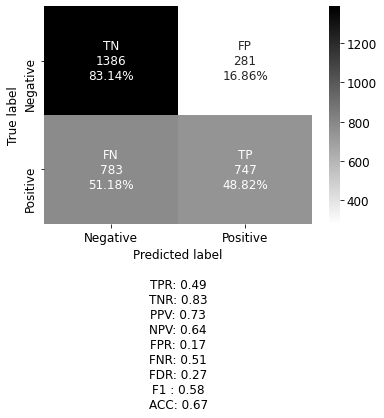

In [21]:
cm_plot(y_test_expt, y_pred, calculate=True, categories=("Negative", "Positive"), legend=True)

In [22]:
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    128  128    1
              Conv2D    \|/  -------------------       320     0.1%
                relu   #####    128  128   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     32   32   32
             Dropout    | || -------------------         0     0.0%
                       #####     32   32   32
              Conv2D    \|/  -------------------     18496     5.8%
                relu   #####     32   32   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      8    8   64
             Dropout    | || -------------------         0     0.0%
                       #####      8    8   64
              Conv2D    \|/  -------------------     36928    11.6%
                relu   #####      8    8   64
        MaxPooling2D   Y max -------------------         0     0.0%
              

In [23]:
with open("last_model_run/model_summary.txt", "w") as writer:
    model.summary(print_fn=lambda x: writer.write(x + '\n'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
__________

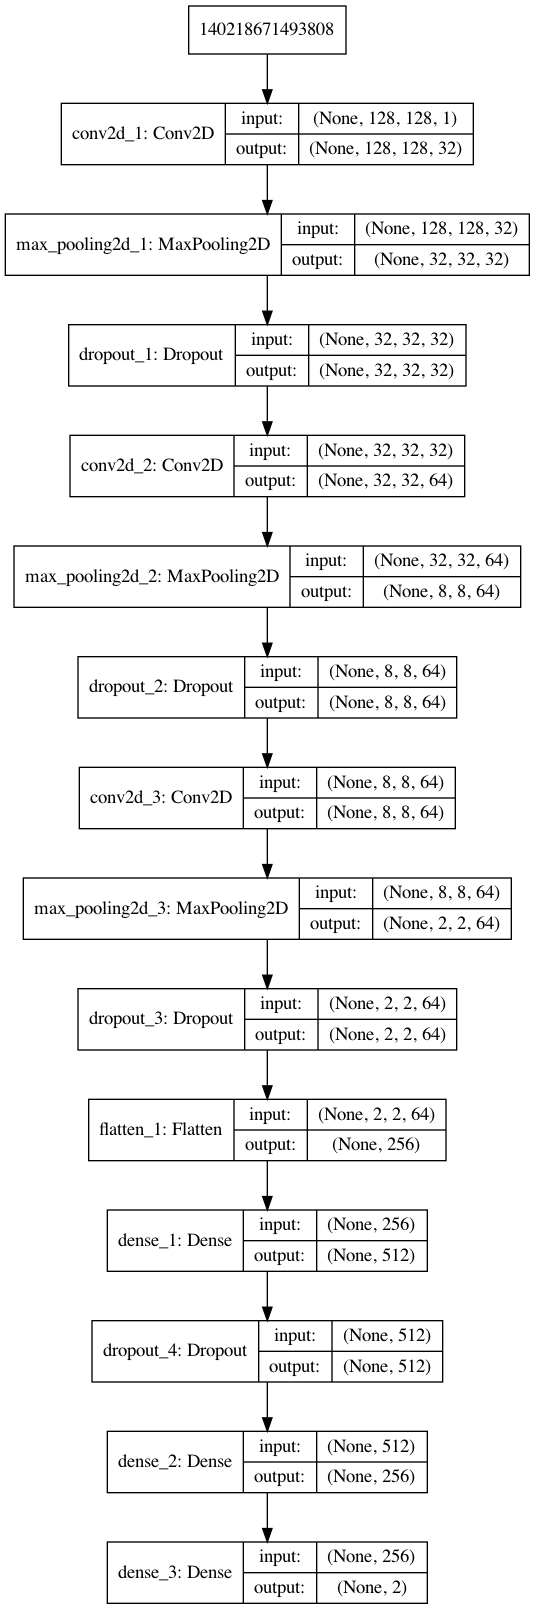

In [24]:
plot_model(model, show_shapes=True, to_file="last_model_run/model.png")
Image("model.png")

In [25]:
ann_viz(model, title="MURA");

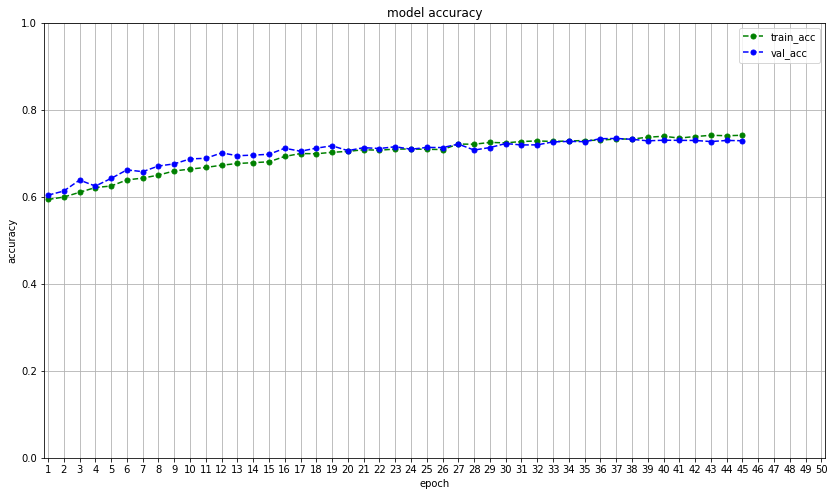

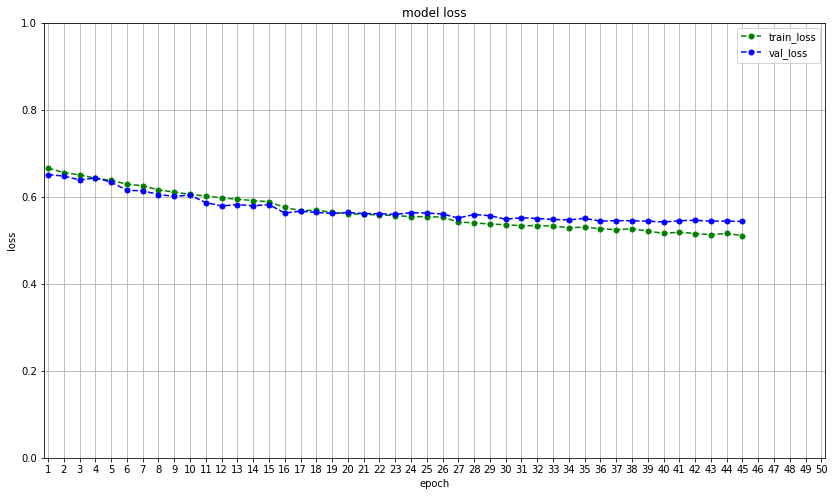

In [26]:
lbl_org = [x for x in range(epochs)]
lbl_new = [x + 1 for x in range(epochs)]

# list all data in history
#print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(14, 8))
plt.plot(history.history["acc"], color="g", linestyle="dashed", marker="o", markerfacecolor="g", markersize=5)
plt.plot(history.history["val_acc"], color="b", linestyle="dashed", marker="o", markerfacecolor="b", markersize=5)
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_acc", "val_acc"]) #, loc="upper left")
plt.xlim(-.25, (max(lbl_org) + 0.25))
plt.xticks(lbl_org, lbl_new)
plt.ylim(0, 1)
plt.grid()
plt.savefig("last_model_run/model accuracy")
plt.show()
plt.close()


max_loss = max(max(history.history["loss"]), max(history.history["val_loss"]))
# summarize history for loss
plt.figure(figsize=(14, 8))
plt.plot(history.history["loss"], color="g", linestyle="dashed", marker="o", markerfacecolor="g", markersize=5)
plt.plot(history.history["val_loss"], color="b", linestyle="dashed", marker="o", markerfacecolor="b", markersize=5)
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"]) #, loc="upper left")
plt.xlim(-.25, (max(lbl_org) + 0.25))
plt.xticks(lbl_org, lbl_new)
if max_loss <= 1:
    plt.ylim(0,1)
else:
    plt.ylim(0, (max_loss + (max_loss *.1)))
plt.grid()
plt.savefig("last_model_run/model loss")
plt.show()
plt.close()

In [27]:
# Manual test
counter = 0
for i in range(len(y_pred)):
    if y_test_expt[i] == y_pred[i]:
        counter += 1

print(counter)
print(len(y_pred))
round((counter / len(y_pred)), 4)

2133
3197


0.6672

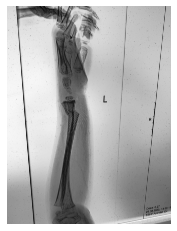

Class: Normal 100.00000%


In [28]:
prediction = model.predict_classes([prepare_img("test/evan_l.jpeg")])
pro = model.predict_proba([prepare_img("test/evan_l.jpeg", show=False)])
print(f"Class: {categories[prediction[0]]} {max(pro[0][0], pro[0][1]):.5%}")

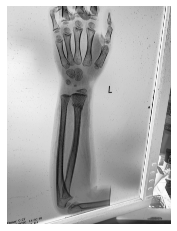

Class: Normal 100.00000%


In [29]:
prediction = model.predict_classes([prepare_img("test/evan_f.jpeg")])
pro = model.predict_proba([prepare_img("test/evan_f.jpeg", show=False)])
print(f"Class: {categories[prediction[0]]} {max(pro[0][0], pro[0][1]):.5%}")

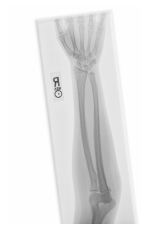

Class: Normal 100.00000%


In [30]:
prediction = model.predict_classes([prepare_img("test/not-evan_l.png")])
pro = model.predict_proba([prepare_img("test/not-evan_l.png", show=False)])
print(f"Class: {categories[prediction[0]]} {max(pro[0][0], pro[0][1]):.5%}")

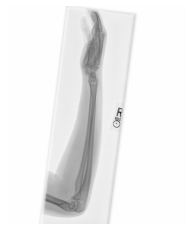

Class: Normal 100.00000%


In [31]:
prediction = model.predict_classes([prepare_img("test/not-evan_f.png")])
pro = model.predict_proba([prepare_img("test/not-evan_f.png", show=False)])
print(f"Class: {categories[prediction[0]]} {max(pro[0][0], pro[0][1]):.5%}")

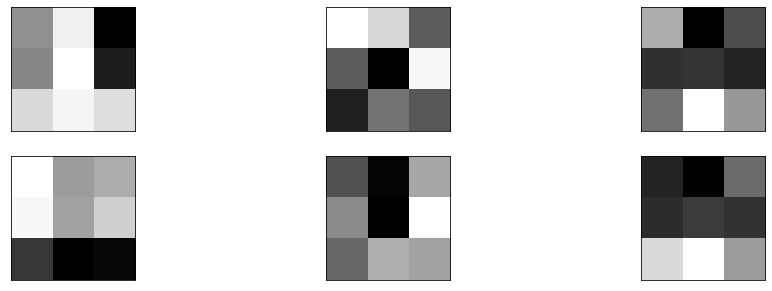

In [32]:
plt.figure(figsize=(16, 16))
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 64)
(1, 8, 8, 64)
(1, 8, 8, 64)
(1, 8, 8, 64)


<ipython-input-33-c6e971e4cc9f>:39: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


(1, 2, 2, 64)
(1, 2, 2, 64)
(1, 256)
(1, 512)
(1, 512)
(1, 256)
(1, 2)


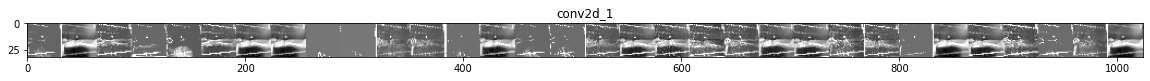

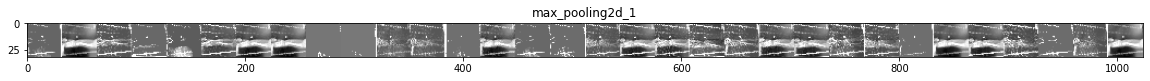

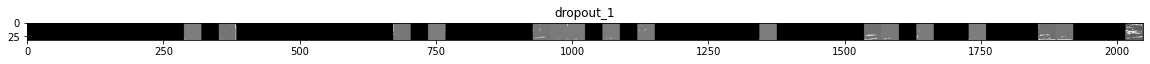

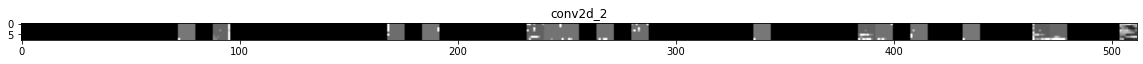

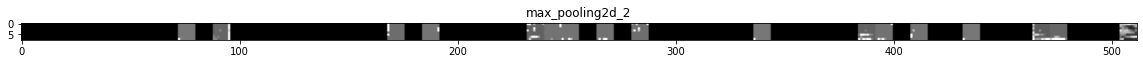

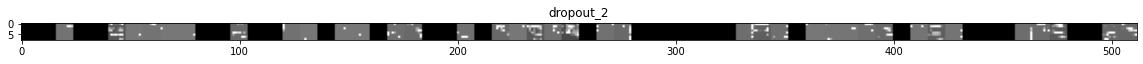

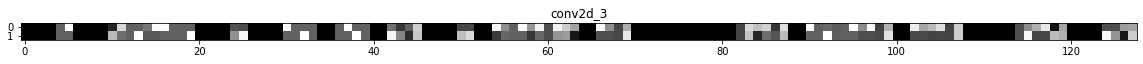

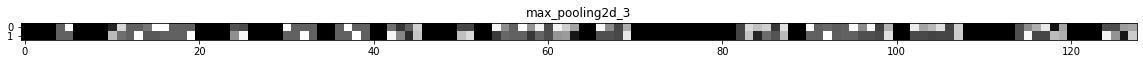

In [33]:
counter = 0
img_path = "test/evan_l.jpeg"  # dog
# Define a new Model, Input= image
# Output= intermediate representations for all layers in the
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = Model(inputs=model.input, outputs=successive_outputs)
# Load the input image
img = load_img(img_path, color_mode="grayscale", target_size=(128, 128))
# Convert ht image to Array of dimension (150,150,3)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) == 4:
        counter += 1

        # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers

        n_features = feature_map.shape[-1]  # number of features in the feature map
        # feature map shape (1, size, size, n_features)
        size = feature_map.shape[1]

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        # Postprocess the feature to be visually palatable
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # Tile each filter into a horizontal grid
            display_grid[:, i * size: (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imsave(f"last_model_run/evan{counter}.png", display_grid)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

Conv:conv2d_1


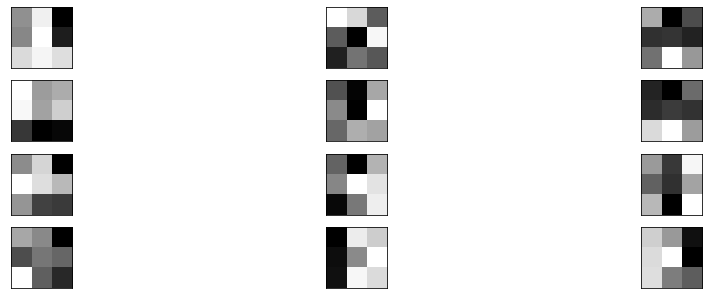

Conv:conv2d_2


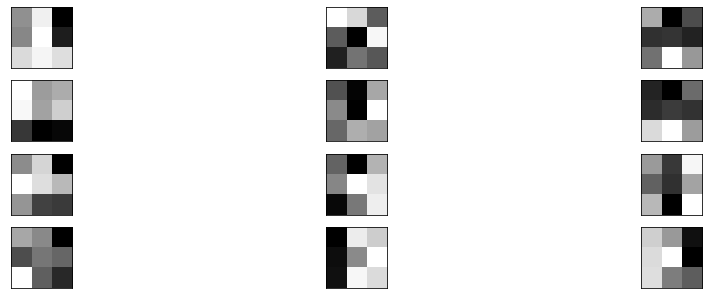

Conv:conv2d_3


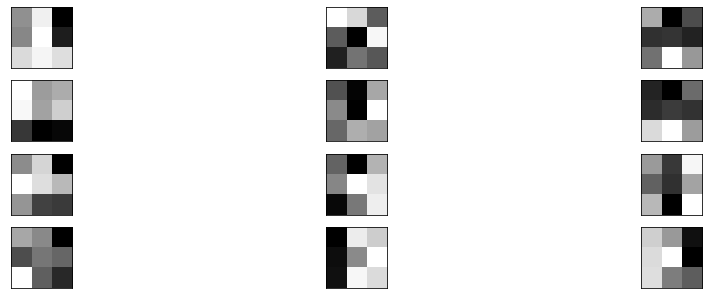

In [34]:
#Iterate thru all the layers of the model
for layer in model.layers:
    if 'conv' in layer.name:
        print(f"Conv:{layer.name}")
        plt.figure(figsize=(16, 16))
        # retrieve weights from the second hidden layer
        filters, biases = model.layers[0].get_weights()
        # normalize filter values to 0-1 so we can visualize them
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)
        # plot first few filters
        n_filters, ix = 12, 1
        for i in range(n_filters):
            # get the filter
            f = filters[:, :, :, i]
            # plot each channel separately
            for j in range(1):
                # specify subplot and turn of axis
                ax = plt.subplot(n_filters, 3, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(f[:, :, j], cmap='gray')
                ix += 1
        # show the figure
        plt.show()

In [35]:
loaded_model = load_model(checkpoint_filepath)

In [36]:
#model.save(Best_model_path)
loaded_y_pred = loaded_model.predict_classes(X_test)

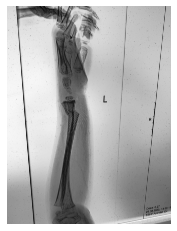

Class: Normal 100.00000%


In [37]:
prediction = loaded_model.predict_classes([prepare_img("test/evan_l.jpeg")])
pro = loaded_model.predict_proba([prepare_img("test/evan_l.jpeg", show=False)])
print(f"Class: {categories[prediction[0]]} {max(pro[0][0], pro[0][1]):.5%}")

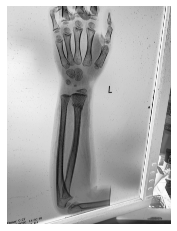

Class: Normal 100.00000%


In [38]:
prediction = loaded_model.predict_classes([prepare_img("test/evan_f.jpeg")])
pro = loaded_model.predict_proba([prepare_img("test/evan_f.jpeg", show=False)])
print(f"Class: {categories[prediction[0]]} {max(pro[0][0], pro[0][1]):.5%}")

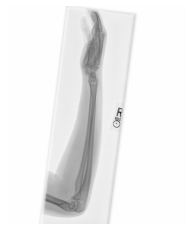

Class: Normal 100.00000%


In [39]:
prediction = loaded_model.predict_classes([prepare_img("test/not-evan_f.png")])
pro = loaded_model.predict_proba([prepare_img("test/not-evan_f.png", show=False)])
print(f"Class: {categories[prediction[0]]} {max(pro[0][0], pro[0][1]):.5%}")

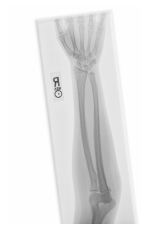

Class: Normal 100.00000%


In [40]:
prediction = loaded_model.predict_classes([prepare_img("test/not-evan_l.png")])
pro = loaded_model.predict_proba([prepare_img("test/not-evan_l.png", show=False)])
print(f"Class: {categories[prediction[0]]} {max(pro[0][0], pro[0][1]):.5%}")